In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


In [4]:
train = pd.read_csv("X_train_minmax_norm_VC.csv", sep = ',',  delim_whitespace=False)
y_train1 = pd.read_csv("y_train_minmax_norm_VC.csv", sep = ',',  delim_whitespace=False)
test = pd.read_csv("X_test_minmax_norm_VC.csv", sep = ',',  delim_whitespace=False) 
y_test1 = pd.read_csv("y_test_minmax_norm_VC.csv", sep = ',',  delim_whitespace=False)

In [5]:
#vado ad unire la mia variabile target perché la regressione la farò su frame_count, no VC

# Unisco i dataset utilizzando il metodo join
X_train_merged = train.join(y_train1)
#trasformo vocal_channel in one -hot 
categorical_cols_vocal_channel = ["vocal_channel"]
X_train = pd.get_dummies(X_train_merged, columns=categorical_cols_vocal_channel)
X = X_train.values

In [6]:
#vado ad unire la mia variabile target perché la regressione la farò su frame_count, no VC

# Unisco i dataset utilizzando il metodo join
X_test_merged = test.join(y_test1)
#trasformo vocal_channel in one -hot 
categorical_cols_vocal_channel_test = ["vocal_channel"]
X_test = pd.get_dummies(X_test_merged, columns=categorical_cols_vocal_channel_test)
X = X_test.values

In [7]:
#eliminiamo tutte le colonne con soli valori nulli
X_train.dropna(axis='columns', how='all', inplace=True)
#eliminiamo tutte le colonne con soli valori nulli
X_test.dropna(axis='columns', how='all', inplace=True)

In [8]:
#qui vado a eliminare le colonne del train che sono più correlate
#in questo caso chiamo la variabile X_train_cleaned

correlation_matrix = X_train.corr()
correlation_threshold = 0.80  # Soglia di correlazione da considerare alta

# Creazione di una lista per tenere traccia delle variabili da eliminare
variables_to_remove = []

# Iterazione attraverso la matrice delle correlazioni
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            variable_i = correlation_matrix.columns[i]
            variable_j = correlation_matrix.columns[j]
            
            # Verifica se una delle variabili è già stata identificata per la rimozione
            if variable_i not in variables_to_remove:
                variables_to_remove.append(variable_j)

# Rimozione delle variabili correlate dal dataset
X_train_cleaned_v = X_train.drop(variables_to_remove, axis=1)



In [9]:
#qui vado a eliminare le colonne del test che sono più correlate
#in questo caso chiamo la variabile X_test_cleaned

correlation_matrix = X_test.corr()
correlation_threshold = 0.80  # Soglia di correlazione da considerare alta

# Creazione di una lista per tenere traccia delle variabili da eliminare
variables_to_remove = []

# Iterazione attraverso la matrice delle correlazioni
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            variable_i = correlation_matrix.columns[i]
            variable_j = correlation_matrix.columns[j]
            
            # Verifica se una delle variabili è già stata identificata per la rimozione
            if variable_i not in variables_to_remove:
                variables_to_remove.append(variable_j)

# Rimozione delle variabili correlate dal dataset
X_test_cleaned = X_test.drop(variables_to_remove, axis=1)



In [10]:
#Train e Test non hanno lo stesso numero di colonne dopo l'eliminazione delle features
#più fortemente correlate

set(X_train_cleaned_v) - set(X_test_cleaned)

{'mfcc_q99', 'q75', 'stft_q75', 'zc_kur'}

In [11]:
X_train_cleaned = X_train_cleaned_v.drop(['mfcc_q99','q75', 'stft_q75', 'zc_kur' ], axis = 1) 

In [12]:
set(X_train_cleaned) - set(X_test_cleaned)

set()

In [13]:
#X_train = X_train.values

#X_test=X_test.values


In [14]:
X_train1 = X_train.drop(['frame_count'], axis = 1)

In [15]:
X_test1 = X_test.drop(['frame_count'], axis = 1)

### GradientBoostingRegressor

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


In [17]:
y_train = train.pop('frame_count')
y_test = test.pop('frame_count')

In [18]:
#y_train = y_train.values
#y_test=y_test.values

In [19]:
from sklearn.model_selection import GridSearchCV

# Definisco i parametri da esplorare (ce ne sono pochi per una prova adesso)
param_grid = {
    'n_estimators': [100],
    'max_depth': [5],
    'learning_rate': [0.1, 0.05, 0.01]
}

regressor = GradientBoostingRegressor()
grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_squared_error', verbose = 1)

# Eseguo la ricerca dei parametri ottimali
grid_search.fit(X_train, y_train)
print("Migliori parametri:", grid_search.best_params_)
print("Migliore score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Effettua previsioni utilizzando il miglior modello
predictions = best_model.predict(X_test)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


KeyboardInterrupt: 

In [20]:
mse = mean_squared_error(y_test, predictions)

NameError: name 'predictions' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 5,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [ ]:
reg = GradientBoostingRegressor(**params)
reg.fit(X_train1, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0071


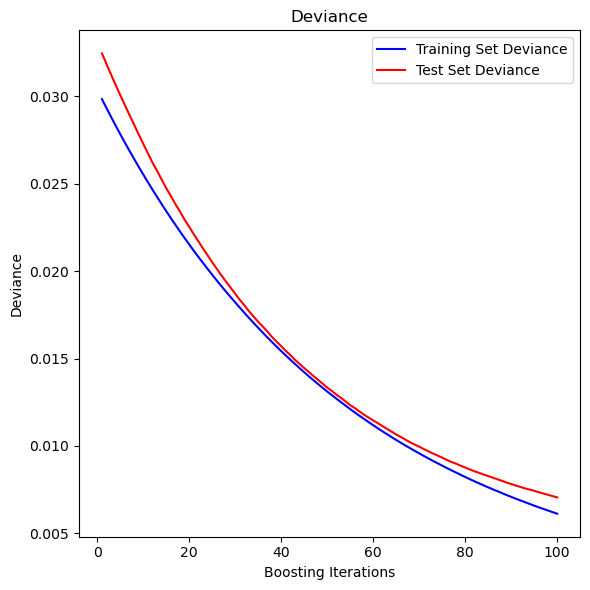

In [ ]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test1)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

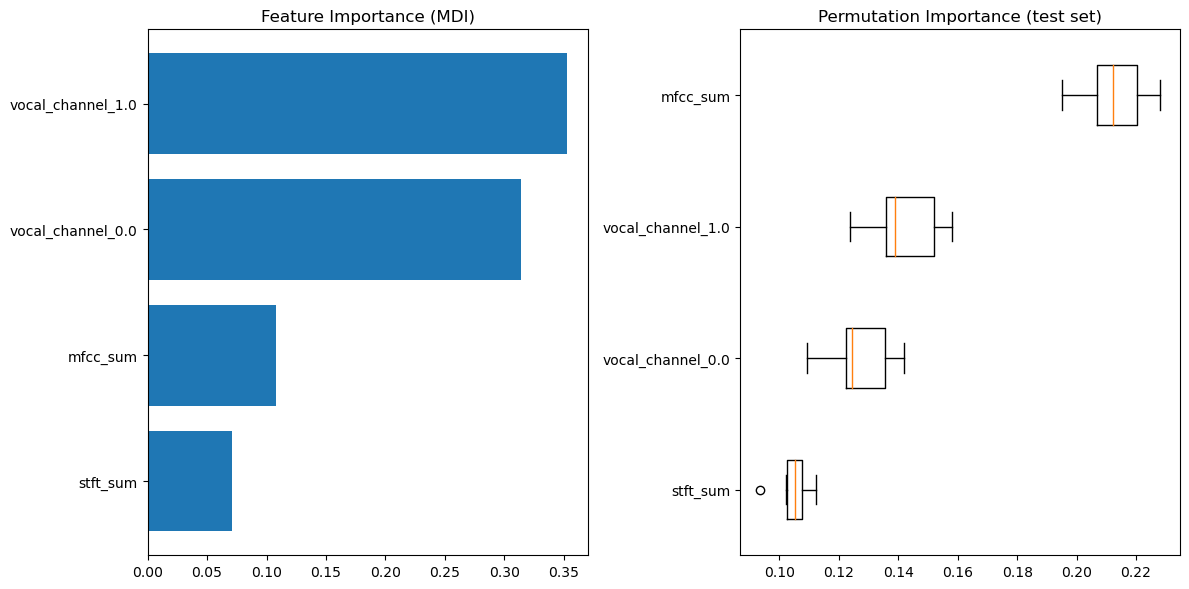

In [ ]:
nbr_features = 4

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)[-nbr_features:]
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train1.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")



result = permutation_importance(
    reg, X_test1, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()[-nbr_features:]
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train1.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()


In [21]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X = rng.randn(n_samples, n_features)
regr = make_pipeline(StandardScaler(), SVR(C=10.0, epsilon=0.2))
regr.fit(X, y)



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=10.0, epsilon=0.2))])

In [ ]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

In [22]:
mse = mean_squared_error(y, regr.predict(X))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0354


In [23]:

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Creazione del modello SVR
svr = SVR()

# Definizione dei parametri per la griglia di ricerca
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.01, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1, 10, 100]
}

# Esecuzione della griglia di ricerca con 5-fold cross-validation
grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Recupero dei migliori iperparametri e dell'errore quadratico medio negativo corrispondente
best_params = grid_search.best_params_
best_mse = grid_search.best_score_

# Creazione del modello SVR finale con i migliori iperparametri
final_svr = SVR(**best_params)
final_svr.fit(X_train, y_train)

# Esecuzione delle previsioni sul set di addestramento e di test
y_train_pred = final_svr.predict(X_train)
y_test_pred = final_svr.predict(X_test)

# Calcolo di R2, MSE per il set di addestramento
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

# Calcolo di R2, MSE per il set di test
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Stampa dei risultati
print("Migliori iperparametri:", best_params)
print("Errore quadratico medio negativo:", best_mse)
print("R2 (set di addestramento):", r2_train)
print("MSE (set di addestramento):", mse_train)
print("R2 (set di test):", r2_test)
print("MSE (set di test):", mse_test)


Migliori iperparametri: {'C': 1, 'epsilon': 0.01, 'kernel': 'linear'}
Errore quadratico medio negativo: -2.9859885592618515e-05
R2 (set di addestramento): 0.9993288562528302
MSE (set di addestramento): 2.038729742194467e-05
R2 (set di test): 0.9817185383527524
MSE (set di test): 0.0006008719072004683


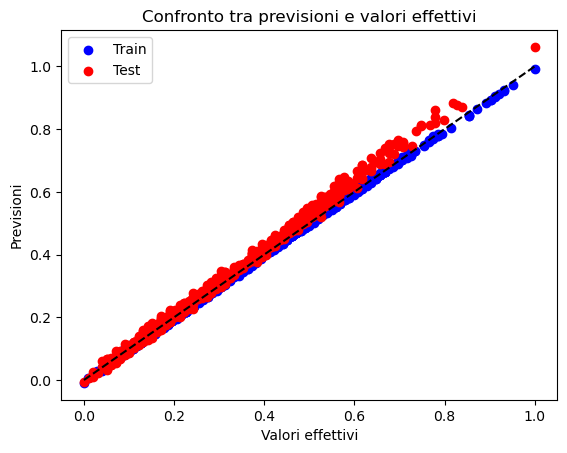

In [24]:

import matplotlib.pyplot as plt

# Creazione del plot per il set di addestramento
plt.scatter(y_train, y_train_pred, color='blue', label='Train')
# Creazione del plot per il set di test
plt.scatter(y_test, y_test_pred, color='red', label='Test')

# Aggiunta della linea di riferimento ideale (x = y)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='--')

# Etichettatura degli assi e della legenda
plt.xlabel('Valori effettivi')
plt.ylabel('Previsioni')
plt.legend()

# Titolo del grafico
plt.title('Confronto tra previsioni e valori effettivi')

# Visualizzazione del grafico
plt.show()
